In [83]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Reshape, Flatten, Conv2DTranspose, Conv2D, LeakyReLU, Dropout, Input, Multiply, Activation
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential

In [112]:
import pandas as pd
import numpy as np
import os
import random
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [48]:
from skimage.io import imread
data_path = 'C:/Users/Duke/Desktop/Data Structures and Algorithms/Python/GAN/data'
root_dir = os.listdir(data_path)
file_list = []
image_list = []
label_list = []

for directory in root_dir:
    directory_path = f"{data_path}/{directory}"
    for file in os.listdir(f"{data_path}/{directory}"):
        file_path = f"{data_path}/{directory}/{file}"
        file_list.append(file_path)
        label_list.append(directory)
        img = imread(file_path)
        image_list.append(np.array(img))
df = pd.DataFrame({'file':file_list,'image':image_list,'label':label_list})
df

,file,image,label
0,C:/Users/Duke/Desktop/Data Structures and Algo...,"[[[195, 146, 142], [195, 146, 142], [195, 146,...",boy
1,C:/Users/Duke/Desktop/Data Structures and Algo...,"[[[33, 19, 8], [34, 20, 9], [34, 20, 9], [34, ...",boy
2,C:/Users/Duke/Desktop/Data Structures and Algo...,"[[[47, 37, 27], [43, 33, 23], [38, 29, 20], [3...",boy
3,C:/Users/Duke/Desktop/Data Structures and Algo...,"[[[124, 120, 85], [120, 116, 81], [118, 113, 8...",boy
4,C:/Users/Duke/Desktop/Data Structures and Algo...,"[[[128, 116, 66], [129, 117, 67], [128, 118, 6...",boy
5,C:/Users/Duke/Desktop/Data Structures and Algo...,"[[[82, 68, 39], [82, 68, 39], [81, 67, 38], [8...",boy
6,C:/Users/Duke/Desktop/Data Structures and Algo...,"[[[42, 33, 26], [38, 29, 22], [36, 27, 20], [3...",boy
7,C:/Users/Duke/Desktop/Data Structures and Algo...,"[[[23, 7, 10], [23, 7, 10], [23, 7, 10], [24, ...",girl
8,C:/Users/Duke/Desktop/Data Structures and Algo...,"[[[253, 255, 254], [253, 255, 254], [253, 255,...",girl
9,C:/Users/Duke/Desktop/Data Structures and Algo...,"[[[152, 121, 57], [150, 119, 55], [149, 118, 5...",girl


In [113]:
categories = {0:"boy", 1:"girl"}

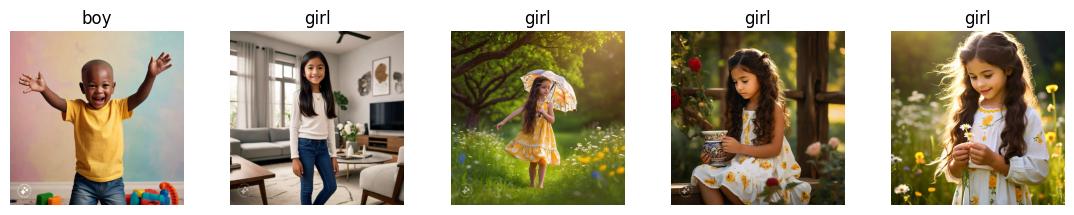

In [116]:
plt.figure(figsize=(11,11))
for i in range(1,6):
    plt.subplot(5,5,i)
    plt.tight_layout()
    plt.axis('off')
    randval = random.choice(list(categories.values()))
    randimg = imread(data_path + '/' + randval + '/' + random.choice(sorted(os.listdir(data_path + '/' + randval + '/'))))
    plt.imshow(randimg)
    plt.title(randval)
    

In [57]:
# split dataframe into train, test, and validation
x_train, x_test0, y_train, y_test0 = train_test_split(df['file'], df['label'], test_size=0.25, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test0, y_test0, test_size=0.5, random_state=42)
train = pd.concat([x_train,y_train], axis=1).reset_index(drop=True)
test = pd.concat([x_test,y_test], axis=1).reset_index(drop=True)
val = pd.concat([x_val, y_val], axis=1).reset_index(drop=True)
print(np.shape(train))
print(np.shape(test))
print(np.shape(val))
test

(10, 2)
(2, 2)
(2, 2)


,file,label
0,C:/Users/Duke/Desktop/Data Structures and Algo...,girl
1,C:/Users/Duke/Desktop/Data Structures and Algo...,boy


In [117]:
from PIL import Image
from keras.preprocessing.image import img_to_array, array_to_img, load_img
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
import cv2 as cv

# normalize image data and transform into train, test, and validation datasets
image_size = 128
batchsize = 32
class_size = 36

datagen = ImageDataGenerator(rescale=1.0/255)

train_data = datagen.flow_from_dataframe(dataframe=train, x_col='file', y_col='label', target_size=(image_size,image_size), batch_size = batchsize, class_mode='categorical')

test_data = datagen.flow_from_dataframe(dataframe=test, x_col='file', y_col='label', target_size=(image_size,image_size), shuffle=False, batch_size=batchsize, class_mode='categorical')

val_data = datagen.flow_from_dataframe(dataframe=val, x_col='file', y_col='label', target_size=(image_size,image_size), shuffle=False, batch_size = batchsize, class_mode='categorical')

Found 10 validated image filenames belonging to 2 classes.
Found 2 validated image filenames belonging to 2 classes.
Found 2 validated image filenames belonging to 1 classes.


In [118]:
#Generator

def build_generator():
    model = Sequential()
    model.add(Dense(256, input_dim=100, activation='relu'))
    model.add(Reshape((4,4,16)))
    model.add(Conv2DTranspose(128, (5,5), strides=(1,1), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    return model

#Discriminator
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same', input_shape=[64, 64,3]))
    model.add(LeakyReLU(alpha=0.2)),
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same')),
    model.add(LeakyReLU(alpha=0.2)),
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

#GAN
generator = build_generator()
discriminator = build_discriminator()
generator.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5))
discriminator.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5))

#Define the GAN model
gan_input = Input(shape=[100])
x = generator(gan_input)
gan_output = discriminator(x)
gan = Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5))
#Train GAN
for epoch in range(100):
    for X_batch, y_batch in train_generator:
        #Generate fake images
        noise = np.random.normal((0,1), size = (X_batch.shape[0], 100))
        fake_images = generator.predict(noise)

        #Train the discriminator
        d_loss_fake= discriminator.train_on_batch(fake_images, np.zeros((X_batch.shape[0], 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        #Train the generator
        g_loss = gan.train_on_batch(noise, y_batch)

ValueError: Exception encountered when calling layer "sequential_61" (type Sequential).

Input 0 of layer "conv2d_45" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 4, 4, 128)

Call arguments received by layer "sequential_61" (type Sequential):
  • inputs=tf.Tensor(shape=(None, 4, 4, 128), dtype=float32)
  • training=None
  • mask=None